# Introduction

### Smaller net: [32,32]

In [30]:
import os
import gymnasium as gym
import torch
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import your custom policy if needed


# --- Load Trained Models ---
seed = 1
env_name = 'CartPole-v1'
agent_type = 'ppo-harmonic'


# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = DummyVecEnv([lambda: env])

# Load models
model_path = f'models/{env_name}/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    model = PPO.load(model_path, env=env)

# Number of episodes and maximum steps per episode
num_episodes = 1
max_steps = 500

state_embeddings = []

for episode in range(num_episodes):
    obs = env.reset()  # Gymnasium reset returns (obs, info)
    ep_return = 0
    for step in range(max_steps):
        # Convert the observation to a tensor (unsqueeze to add batch dim)
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        
        # Extract the state embedding via the model's mlp_extractor.
        # The mlp_extractor returns (features_pi, features_vf)
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        
        # Append the extracted embedding (remove the batch dimension)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
        
        # Get action from the model and step the environment
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        ep_return += reward
        if done:
            break

    print(f'Return = {ep_return}')

state_embeddings = np.array(state_embeddings)
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[2]) 
print("State Embeddings shape:", state_embeddings.shape)

# Action embeddings (for Harmonic approach)
harmonic_policy = model.policy  # This is the HarmonicPolicy instance
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)


Return = [500.]
State Embeddings shape: (500, 16)
Action Embeddings Shape: (2, 16)


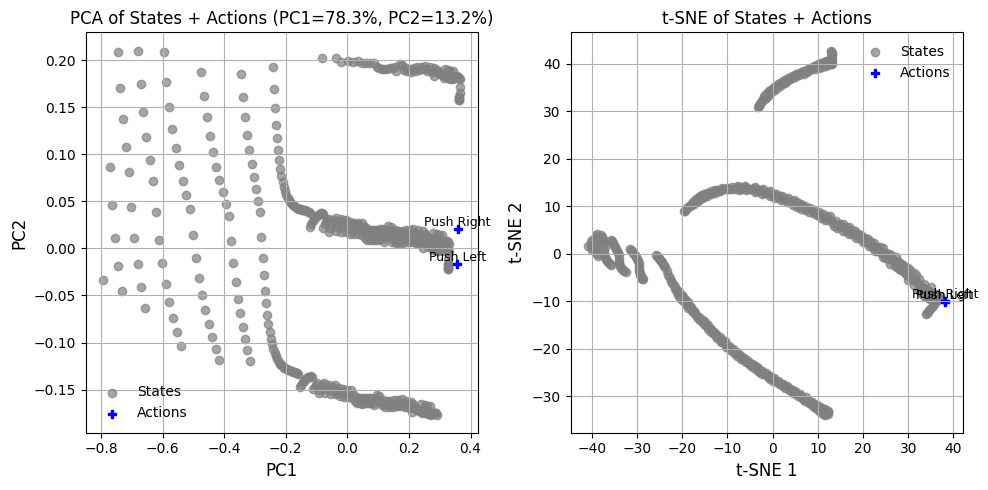

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# For CartPole, we now have 2 actions: 0: "Push Left", 1: "Push Right"
action_labels = ["Push Left", "Push Right"]

# Combine states and actions
combined = np.vstack([state_embeddings, action_embeddings])

# Run PCA on the combined embeddings
pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

# Split the PCA result back into states vs. actions
num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

# Run t-SNE on the combined embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
combined_tsne = tsne.fit_transform(combined)

# Split the t-SNE result back into states vs. actions
tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plot PCA ---
plt.figure(figsize=(10, 5))

# Left subplot: PCA
plt.subplot(1, 2, 1)

# Plot states (grey dots)
plt.scatter(pca_states[:, 0], pca_states[:, 1], color='grey', alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate states (if you have coordinates available)
# for i, (r, c) in enumerate(coords):
#     x, y = pca_states[i]
#     plt.annotate(f"({r},{c})", (x, y), fontsize=7, alpha=0.7)

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# --- Plot t-SNE ---
plt.subplot(1, 2, 2)

# Plot states (grey dots)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], color='grey', alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate states
# for i, (r, c) in enumerate(coords):
#     x, y = tsne_states[i]
#     plt.annotate(f"({r},{c})", (x, y), fontsize=7, alpha=0.7)

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Bigger net: [128, 128, 128]

In [56]:
import os
import gymnasium as gym
import torch
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import your custom policy if needed


# --- Load Trained Models ---
seed = 3
seed = 11
env_name = 'CartPole-v1'
agent_type = 'ppo-harmonic'


# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = DummyVecEnv([lambda: env])

# Load models
model_path = f'models/{env_name}-big/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    model = PPO.load(model_path, env=env)

# Number of episodes and maximum steps per episode
num_episodes = 1
max_steps = 500

state_embeddings = []

for episode in range(num_episodes):
    obs = env.reset()  # Gymnasium reset returns (obs, info)
    ep_return = 0
    for step in range(max_steps):
        # Convert the observation to a tensor (unsqueeze to add batch dim)
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        
        # Extract the state embedding via the model's mlp_extractor.
        # The mlp_extractor returns (features_pi, features_vf)
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        
        # Append the extracted embedding (remove the batch dimension)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
        
        # Get action from the model and step the environment
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        ep_return += reward
        if done:
            break

    print(f'Return = {ep_return}')

state_embeddings = np.array(state_embeddings)
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[2]) 
print("State Embeddings shape:", state_embeddings.shape)

# Action embeddings (for Harmonic approach)
harmonic_policy = model.policy  # This is the HarmonicPolicy instance
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)


Return = [500.]
State Embeddings shape: (500, 128)
Action Embeddings Shape: (2, 128)


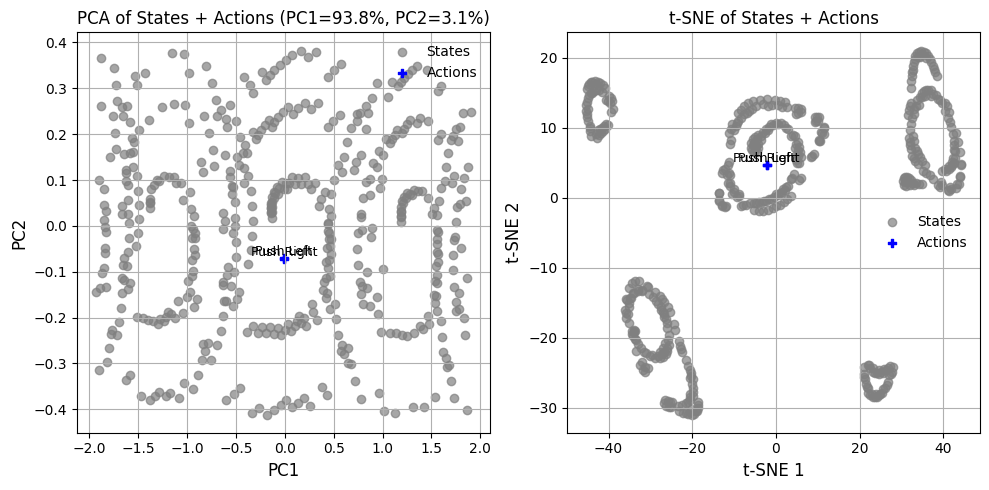

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# For CartPole, we now have 2 actions: 0: "Push Left", 1: "Push Right"
action_labels = ["Push Left", "Push Right"]

# Combine states and actions
combined = np.vstack([state_embeddings, action_embeddings])

# Run PCA on the combined embeddings
pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

# Split the PCA result back into states vs. actions
num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

# Run t-SNE on the combined embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
combined_tsne = tsne.fit_transform(combined)

# Split the t-SNE result back into states vs. actions
tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plot PCA ---
plt.figure(figsize=(10, 5))

# Left subplot: PCA
plt.subplot(1, 2, 1)

# Plot states (grey dots)
plt.scatter(pca_states[:, 0], pca_states[:, 1], color='grey', alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate states (if you have coordinates available)
# for i, (r, c) in enumerate(coords):
#     x, y = pca_states[i]
#     plt.annotate(f"({r},{c})", (x, y), fontsize=7, alpha=0.7)

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# --- Plot t-SNE ---
plt.subplot(1, 2, 2)

# Plot states (grey dots)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], color='grey', alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate states
# for i, (r, c) in enumerate(coords):
#     x, y = tsne_states[i]
#     plt.annotate(f"({r},{c})", (x, y), fontsize=7, alpha=0.7)

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Roughwork

Seed 0 - State Embeddings shape: (175, 128)
Seed 0 - Action Embeddings shape: (2, 128)
Seed 1 - State Embeddings shape: (285, 128)
Seed 1 - Action Embeddings shape: (2, 128)
Seed 2 - State Embeddings shape: (34, 128)
Seed 2 - Action Embeddings shape: (2, 128)
Seed 3 - State Embeddings shape: (500, 128)
Seed 3 - Action Embeddings shape: (2, 128)
Seed 4 - State Embeddings shape: (146, 128)
Seed 4 - Action Embeddings shape: (2, 128)
Seed 5 - State Embeddings shape: (139, 128)
Seed 5 - Action Embeddings shape: (2, 128)
Seed 6 - State Embeddings shape: (59, 128)
Seed 6 - Action Embeddings shape: (2, 128)
Seed 7 - State Embeddings shape: (145, 128)
Seed 7 - Action Embeddings shape: (2, 128)
Seed 8 - State Embeddings shape: (173, 128)
Seed 8 - Action Embeddings shape: (2, 128)
Seed 9 - State Embeddings shape: (34, 128)
Seed 9 - Action Embeddings shape: (2, 128)
Seed 10 - State Embeddings shape: (55, 128)
Seed 10 - Action Embeddings shape: (2, 128)
Seed 11 - State Embeddings shape: (500, 128)


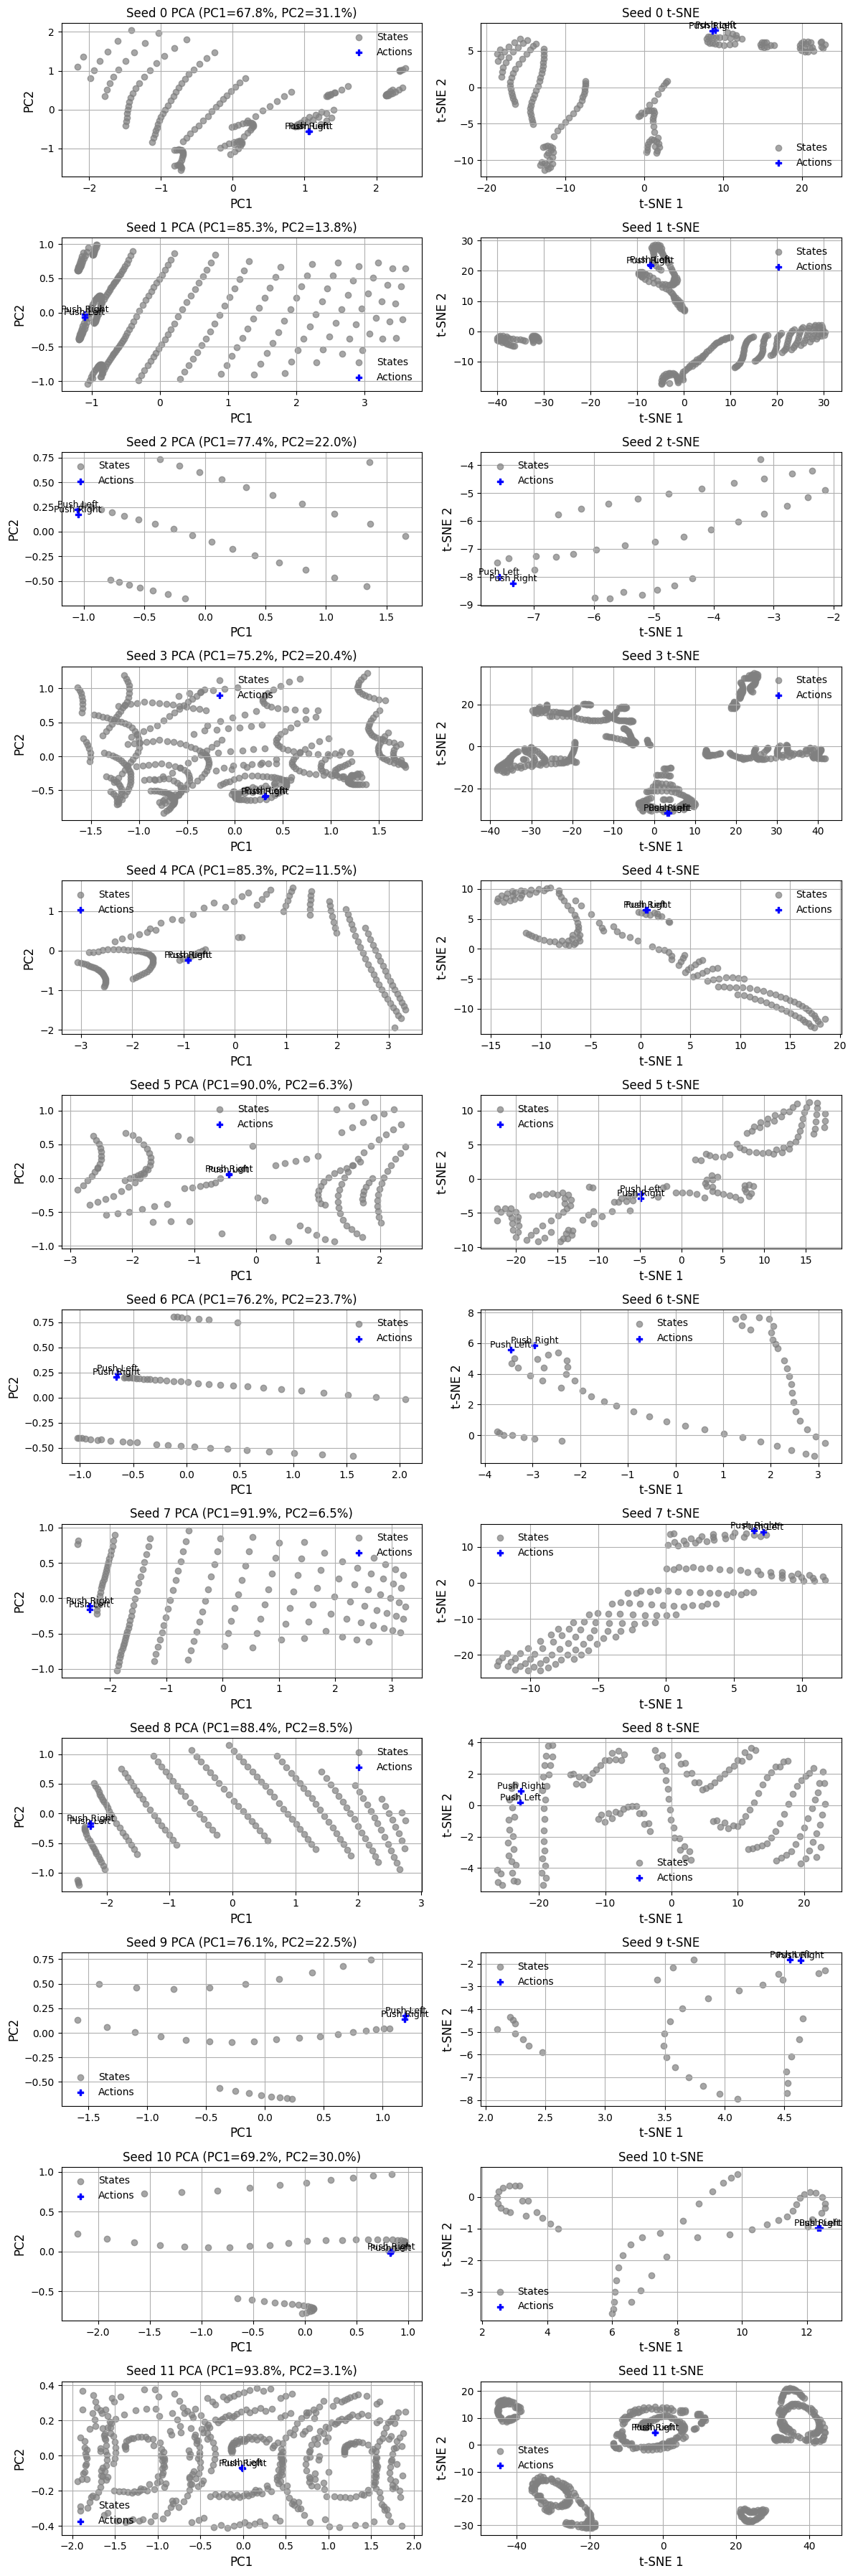

In [62]:
import os
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Your custom policy

# Parameters
ensemble_seeds = list(range(12))  # Seeds 0 to 11
env_name = 'CartPole-v1'
agent_type = 'ppo-harmonic'
num_episodes = 1
max_steps = 500

# Prepare subplots: 12 rows x 2 columns
fig, axes = plt.subplots(len(ensemble_seeds), 2, figsize=(12, len(ensemble_seeds)*3))

# For CartPole, we have 2 actions.
action_labels = ["Push Left", "Push Right"]

for i, seed in enumerate(ensemble_seeds):
    # Create and seed environment
    env = gym.make(env_name)
    env.reset()
    env = DummyVecEnv([lambda: env])

    # Build model path; adjust path if needed.
    model_path = f'models/{env_name}-big/{agent_type}_{seed}.zip'
    if os.path.exists(model_path):
        model = PPO.load(model_path, env=env)
    else:
        print(f"Model for seed {seed} not found. Skipping.")
        continue

    state_embeddings_list = []
    
    # Run one episode and collect state embeddings
    obs = env.reset()  # Gymnasium reset returns (obs, info)
    for step in range(max_steps):
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        # Extract embedding from the policy's MLP extractor.
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        embedding = features_pi.detach().squeeze(0).cpu().numpy()
        state_embeddings_list.append(embedding)
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        if done:
            break

    # Convert list to NumPy array and automatically flatten extra dims.
    state_embeddings = np.array(state_embeddings_list)
    num_samples = state_embeddings.shape[0]
    state_embeddings = state_embeddings.reshape(num_samples, -1)
    print(f"Seed {seed} - State Embeddings shape: {state_embeddings.shape}")

    # Action embeddings from the harmonic policy (assumed to be stored in 'weights')
    harmonic_policy = model.policy
    action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
    print(f"Seed {seed} - Action Embeddings shape: {action_embeddings.shape}")

    # Combine states and actions for visualization
    combined = np.vstack([state_embeddings, action_embeddings])
    
    # PCA
    pca = PCA(n_components=2)
    combined_pca = pca.fit_transform(combined)
    num_states = state_embeddings.shape[0]
    pca_states = combined_pca[:num_states]
    pca_actions = combined_pca[num_states:]
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=20)
    combined_tsne = tsne.fit_transform(combined)
    tsne_states = combined_tsne[:num_states]
    tsne_actions = combined_tsne[num_states:]
    
    # Plot PCA in left subplot of row i
    ax_pca = axes[i, 0]
    ax_pca.scatter(pca_states[:, 0], pca_states[:, 1], color='grey', alpha=0.7, label='States')
    ax_pca.scatter(pca_actions[:, 0], pca_actions[:, 1], c='blue', marker='P', label='Actions')
    for j, label in enumerate(action_labels):
        x, y = pca_actions[j]
        ax_pca.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')
    var_ratio = pca.explained_variance_ratio_
    pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
    ax_pca.set_title(f"Seed {seed} PCA (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
    ax_pca.set_xlabel("PC1")
    ax_pca.set_ylabel("PC2")
    ax_pca.grid(True)
    ax_pca.legend()

    # Plot t-SNE in right subplot of row i
    ax_tsne = axes[i, 1]
    ax_tsne.scatter(tsne_states[:, 0], tsne_states[:, 1], color='grey', alpha=0.7, label='States')
    ax_tsne.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='blue', marker='P', label='Actions')
    for j, label in enumerate(action_labels):
        x, y = tsne_actions[j]
        ax_tsne.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')
    ax_tsne.set_title(f"Seed {seed} t-SNE")
    ax_tsne.set_xlabel("t-SNE 1")
    ax_tsne.set_ylabel("t-SNE 2")
    ax_tsne.grid(True)
    ax_tsne.legend()

plt.tight_layout()
plt.show()

### Stuff here

In [101]:
import os
import gymnasium as gym
import torch
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import your custom policy if needed


# --- Load Trained Models ---
seed = 2
env_name = 'LunarLander-v2'
agent_type = 'ppo-harmonic'


# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = DummyVecEnv([lambda: env])

# Load models
model_path = f'models/{env_name}/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    model = PPO.load(model_path, env=env)

# Number of episodes and maximum steps per episode
num_episodes = 10
state_embeddings = []
for episode in range(num_episodes):
    obs = env.reset()  # Gymnasium reset returns (obs, info)
    ep_return = 0
    done = False
    while not done:
        # Convert the observation to a tensor (unsqueeze to add batch dim)
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        
        # Extract the state embedding via the model's mlp_extractor.
        # The mlp_extractor returns (features_pi, features_vf)
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        
        # Append the extracted embedding (remove the batch dimension)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
        
        # Get action from the model and step the environment
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        ep_return += reward

    print(f'Return = {ep_return}')

state_embeddings = np.array(state_embeddings)
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[2]) 
print("State Embeddings shape:", state_embeddings.shape)

# Action embeddings (for Harmonic approach)
harmonic_policy = model.policy  # This is the HarmonicPolicy instance
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)

Return = [225.15045]
Return = [222.34622]
Return = [205.73643]
Return = [254.43842]
Return = [226.3681]
Return = [240.0548]
Return = [242.32382]
Return = [264.24973]
Return = [-33.993927]
Return = [276.16705]
State Embeddings shape: (3636, 128)
Action Embeddings Shape: (4, 128)


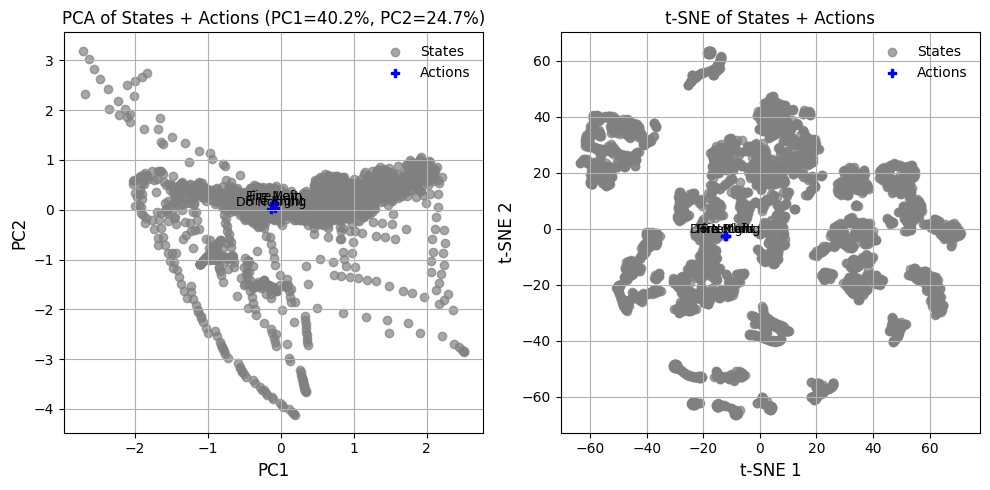

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# For LunarLander-v2, we have 4 actions:
action_labels = ["Do Nothing", "Fire Left", "Fire Main", "Fire Right"]

# Combine states and actions
combined = np.vstack([state_embeddings, action_embeddings])

# Run PCA on the combined embeddings
pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

# Split the PCA result back into states vs. actions
num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

# Run t-SNE on the combined embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
combined_tsne = tsne.fit_transform(combined)

# Split the t-SNE result back into states vs. actions
tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plot PCA ---
plt.figure(figsize=(10, 5))

# Left subplot: PCA
plt.subplot(1, 2, 1)

# Plot states (grey dots)
plt.scatter(pca_states[:, 0], pca_states[:, 1], color='grey', alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# --- Plot t-SNE ---
plt.subplot(1, 2, 2)

# Plot states (grey dots)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], color='grey', alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

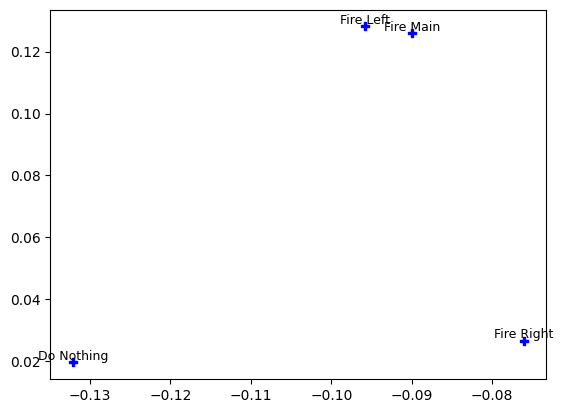

In [103]:
# Plot actions (blue 'P' markers)
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

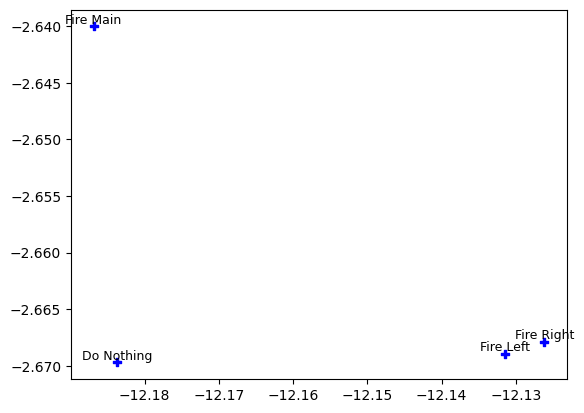

In [104]:
# Plot actions (blue 'P' markers)
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

### HEre

Return = [500.]
State Embeddings shape: (500, 128)
Action Embeddings Shape: (2, 128)


/var/folders/y2/808x0vrs0219dlwh974ks0q00000gn/T/ipykernel_81254/3566651096.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('bwr')


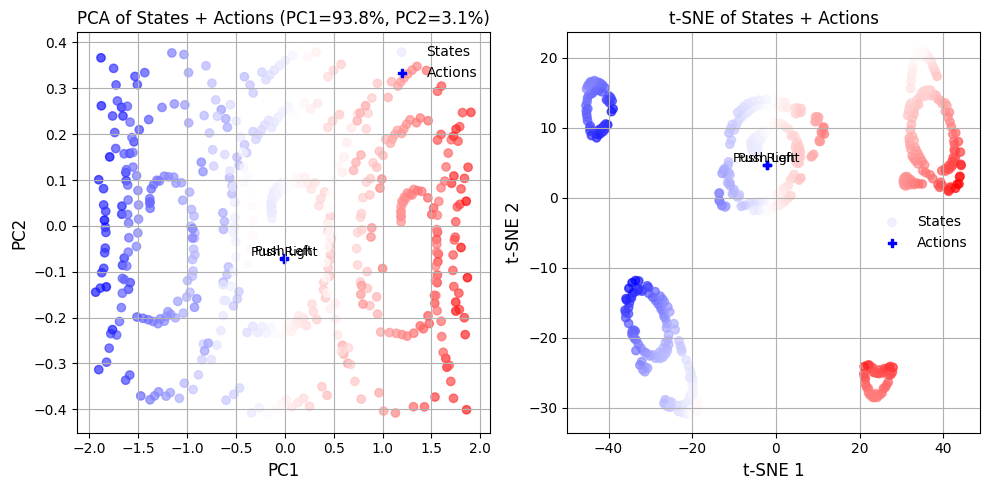

In [10]:
import os
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.colors as colors
import matplotlib.cm as cm
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import your custom policy if needed

# --- Load Trained Models ---
seed = 11
env_name = 'CartPole-v1'
agent_type = 'ppo-harmonic'

# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = DummyVecEnv([lambda: env])

# Load model
model_path = f'models/{env_name}-big/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    model = PPO.load(model_path, env=env)

# Number of episodes and maximum steps per episode
num_episodes = 1
max_steps = 500

state_embeddings = []
theta_dot_values = []  # To store the pole angular velocity (dot(theta)) for each state

for episode in range(num_episodes):
    obs = env.reset()  # Gymnasium reset returns obs (and info in newer versions)
    ep_return = 0
    for step in range(max_steps):
        # Convert the observation to a tensor (unsqueeze to add batch dim)
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        
        # Extract the state embedding via the model's mlp_extractor.
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        
        # Append the extracted embedding (remove the batch dimension)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
        
        # CartPole-v1 observation is [cart position, cart velocity, pole angle, pole velocity at tip].
        # We'll color by dot(theta), i.e., index 3 in the observation.
        dot_theta = obs[0][3]
        theta_dot_values.append(dot_theta)
        
        # Get action from the model and step the environment
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        ep_return += reward
        if done:
            break

    print(f'Return = {ep_return}')

state_embeddings = np.array(state_embeddings)
# Adjust shape if needed: assume state_embeddings shape is (num_states, embedding_dim)
# If there's an extra dimension, reshape accordingly:
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[-1])
print("State Embeddings shape:", state_embeddings.shape)

# Action embeddings (for Harmonic approach)
harmonic_policy = model.policy  # This is the HarmonicPolicy instance
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)

# --- Prepare Colors for States ---
theta_dot_values = np.array(theta_dot_values)
# Normalize dot(theta) with midpoint at 0 (blue for negative, red for positive)
norm = colors.TwoSlopeNorm(vmin=np.min(theta_dot_values), vcenter=0, vmax=np.max(theta_dot_values))
cmap = cm.get_cmap('bwr')
state_colors = cmap(norm(theta_dot_values))

# --- Combine states and actions ---
combined = np.vstack([state_embeddings, action_embeddings])

# Run PCA on the combined embeddings
pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

# Split the PCA result back into states vs. actions
num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

# Run t-SNE on the combined embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
combined_tsne = tsne.fit_transform(combined)

# Split the t-SNE result back into states vs. actions
tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plot PCA ---
plt.figure(figsize=(10, 5))

# Left subplot: PCA
plt.subplot(1, 2, 1)

# Plot states with colors based on dot(theta)
plt.scatter(pca_states[:, 0], pca_states[:, 1], color=state_colors, alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate action points with the updated labels
action_labels = ["Push Left", "Push Right"]
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# --- Plot t-SNE ---
plt.subplot(1, 2, 2)

# Plot states with colors based on dot(theta)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], color=state_colors, alpha=0.7, label='States')

# Plot actions (blue 'P' markers)
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='blue', marker='P', label='Actions')

# Annotate action points with the updated labels
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Return = [500.]
State Embeddings shape: (500, 128)
Action Embeddings Shape: (2, 128)


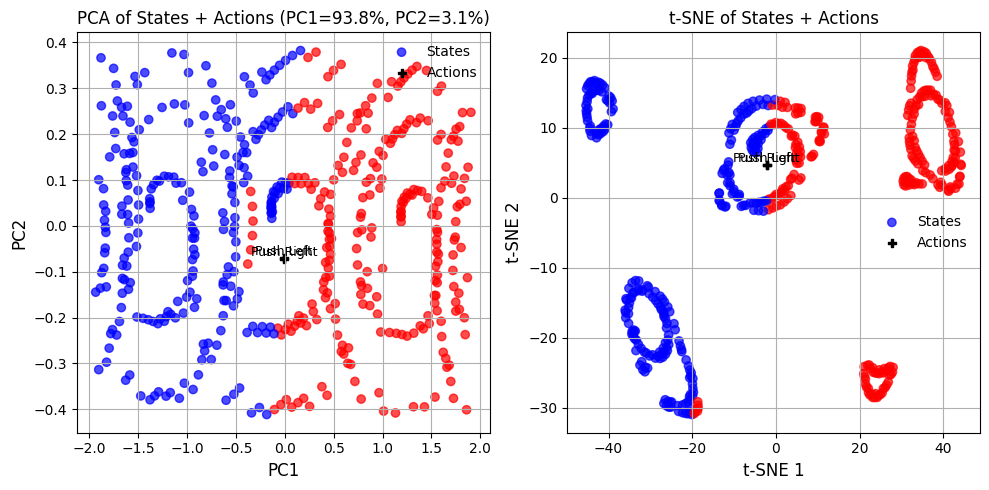

In [12]:
import os
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import your custom policy if needed

# --- Load Trained Models ---
seed = 11
env_name = 'CartPole-v1'
agent_type = 'ppo-harmonic'

# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = DummyVecEnv([lambda: env])

# Load model
model_path = f'models/{env_name}-big/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    model = PPO.load(model_path, env=env)

# Number of episodes and maximum steps per episode
num_episodes = 1
max_steps = 500

state_embeddings = []
theta_dot_values = []  # We'll color states by the sign of pole velocity at tip (dot(theta))

for episode in range(num_episodes):
    obs = env.reset()
    ep_return = 0
    for step in range(max_steps):
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
        
        # CartPole-v1 observation: [x, x_dot, theta, theta_dot]
        dot_theta = obs[0][3]  # index 3
        theta_dot_values.append(dot_theta)
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        ep_return += reward
        if done:
            break

    print(f'Return = {ep_return}')

state_embeddings = np.array(state_embeddings)
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[-1])
print("State Embeddings shape:", state_embeddings.shape)

# Action embeddings (for Harmonic approach)
harmonic_policy = model.policy
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)

# --- Prepare 2-color scheme for states based on sign of dot(theta) ---
theta_dot_values = np.array(theta_dot_values)
# We'll color states 'blue' if dot(theta) < 0, and 'red' if dot(theta) >= 0
state_colors = np.where(theta_dot_values >= 0, 'red', 'blue')

# --- Combine states + actions for PCA & t-SNE ---
combined = np.vstack([state_embeddings, action_embeddings])

pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
combined_tsne = tsne.fit_transform(combined)

tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plot ---
plt.figure(figsize=(10, 5))

action_labels = ["Push Left", "Push Right"]

# PCA subplot
plt.subplot(1, 2, 1)
plt.scatter(pca_states[:, 0], pca_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# t-SNE subplot
plt.subplot(1, 2, 2)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### New env

Return = [-70.]
State Embeddings shape: (71, 128)
Action Embeddings Shape: (3, 128)


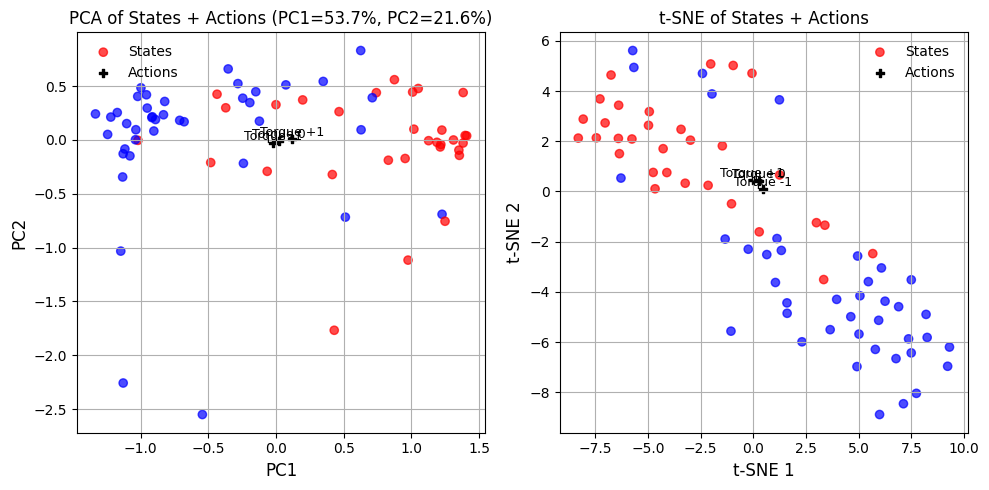

In [19]:
import os
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import your custom policy if needed

# --- Load Trained Models ---
seed = 3
env_name = 'Acrobot-v1'
agent_type = 'ppo-harmonic'

# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = DummyVecEnv([lambda: env])

# Load model
model_path = f'models/{env_name}-big/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    model = PPO.load(model_path, env=env)

# Number of episodes and maximum steps per episode
num_episodes = 1
max_steps = 500

state_embeddings = []
dot_theta2_values = []  # We'll color states by the sign of thetaDot2 (index 5)

for episode in range(num_episodes):
    obs = env.reset()
    ep_return = 0
    for step in range(max_steps):
        # Convert the observation to a tensor (unsqueeze to add batch dim)
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        
        # Extract the state embedding via the model's mlp_extractor.
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
        
        # Acrobot-v1 observation:
        # [cos(theta1), sin(theta1), cos(theta2), sin(theta2), thetaDot1, thetaDot2]
        # We'll color by the sign of thetaDot2 => index 5
        dot_theta2 = obs[0][5]
        dot_theta2_values.append(dot_theta2)
        
        # Get action from the model and step the environment
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        ep_return += reward
        if done:
            break

    print(f'Return = {ep_return}')

# Convert to numpy arrays
state_embeddings = np.array(state_embeddings)
# If shape is (num_samples, 1, embedding_dim), reshape to (num_samples, embedding_dim)
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[-1])
print("State Embeddings shape:", state_embeddings.shape)

dot_theta2_values = np.array(dot_theta2_values)

# Action embeddings (for Harmonic approach)
harmonic_policy = model.policy
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)

# --- Prepare 2-color scheme for states based on sign of thetaDot2 ---
# We'll color states 'blue' if dot(theta2) < 0, and 'red' if dot(theta2) >= 0
state_colors = np.where(dot_theta2_values >= 0, 'red', 'blue')

# --- Combine states + actions for PCA & t-SNE ---
combined = np.vstack([state_embeddings, action_embeddings])

pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
combined_tsne = tsne.fit_transform(combined)

tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plot ---
plt.figure(figsize=(10, 5))

# Update action labels for Acrobot (3 discrete actions)
action_labels = ["Torque -1", "Torque 0", "Torque +1"]

# PCA subplot
plt.subplot(1, 2, 1)
plt.scatter(pca_states[:, 0], pca_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# t-SNE subplot
plt.subplot(1, 2, 2)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Mountain car

Return = [-114.]
State Embeddings shape: (114, 128)
Action Embeddings Shape: (3, 128)


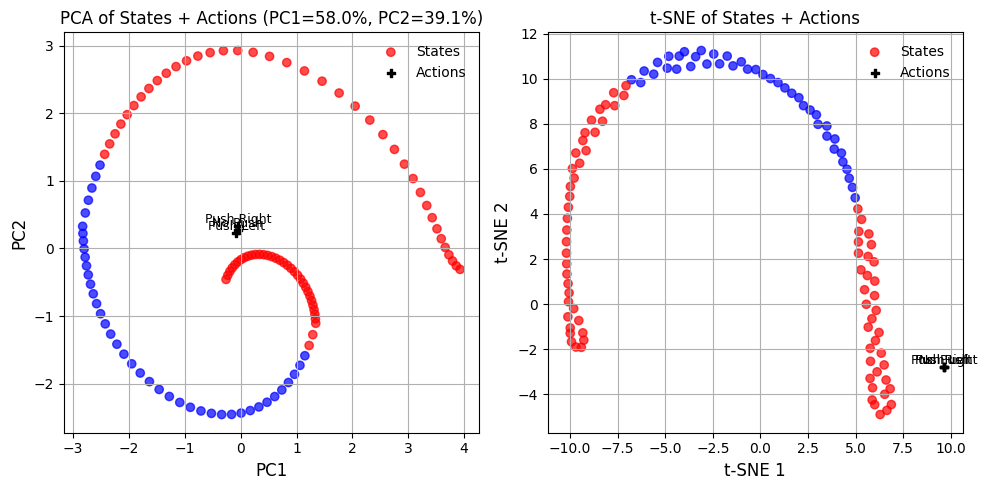

In [39]:
import os
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import your custom policy if needed

# --- Load Trained Models ---
seed = 2
env_name = 'MountainCar-v0'
agent_type = 'ppo-harmonic'

# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = DummyVecEnv([lambda: env])

# Load model
model_path = f'models/{env_name}/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    model = PPO.load(model_path, env=env)

# Number of episodes and maximum steps per episode
num_episodes = 1
max_steps = 500

state_embeddings = []
velocity_values = []  # We'll color states by sign of velocity => index 1 for MountainCar

for episode in range(num_episodes):
    obs = env.reset()
    ep_return = 0
    for step in range(max_steps):
        # Convert the observation to a tensor (unsqueeze to add batch dim)
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        
        # Extract the state embedding via the model's mlp_extractor.
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
        
        # MountainCar-v0 observation: [position, velocity]
        # We'll color by sign of velocity => index 1
        velocity = obs[0][1]
        velocity_values.append(velocity)
        
        # Get action from the model and step the environment
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        ep_return += reward
        if done:
            break

    print(f'Return = {ep_return}')

# Convert to numpy arrays
state_embeddings = np.array(state_embeddings)
# If shape is (num_samples, 1, embedding_dim), reshape to (num_samples, embedding_dim)
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[-1])
print("State Embeddings shape:", state_embeddings.shape)

velocity_values = np.array(velocity_values)

# Action embeddings (for Harmonic approach)
harmonic_policy = model.policy
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)

# --- Prepare 2-color scheme for states based on sign of velocity ---
# We'll color states 'blue' if velocity < 0, and 'red' if velocity >= 0
state_colors = np.where(velocity_values >= 0, 'red', 'blue')

# --- Combine states + actions for PCA & t-SNE ---
combined = np.vstack([state_embeddings, action_embeddings])

pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
combined_tsne = tsne.fit_transform(combined)

tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plot ---
plt.figure(figsize=(10, 5))

# Action labels for MountainCar (3 discrete actions)
action_labels = ["Push Left", "No Push", "Push Right"]

# PCA subplot
plt.subplot(1, 2, 1)
plt.scatter(pca_states[:, 0], pca_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# t-SNE subplot
plt.subplot(1, 2, 2)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

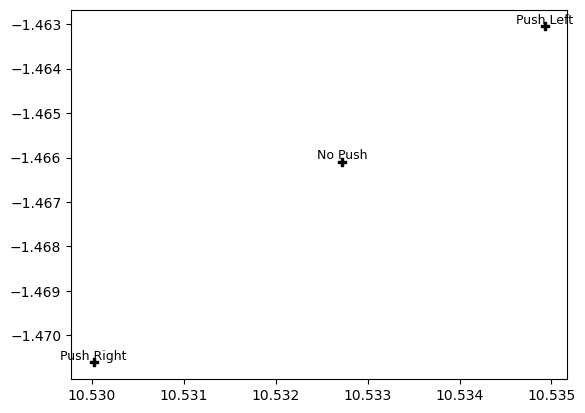

In [36]:
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

here
Return = [-114.]
State Embeddings shape: (114, 128)
Action Embeddings Shape: (3, 128)


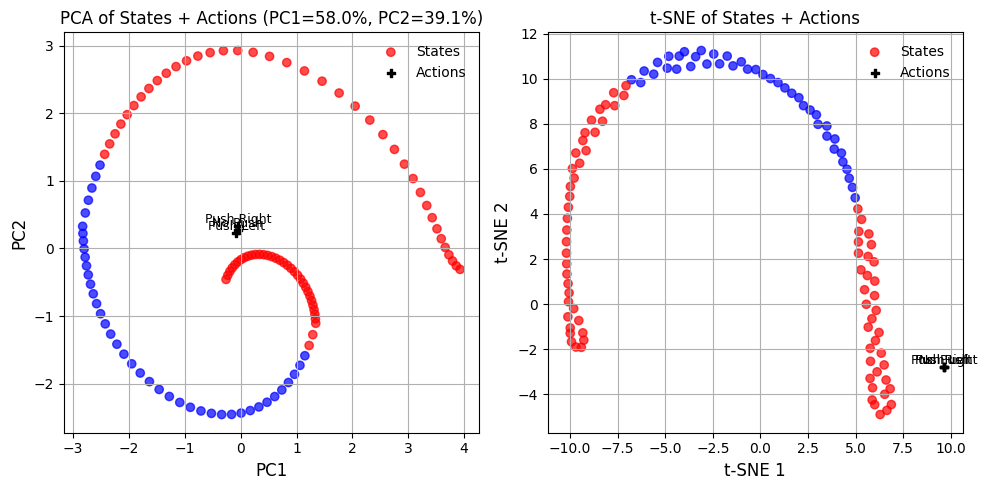

In [41]:
import os
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import your custom policy if needed

# --- Load Trained Models ---
seed = 2
env_name = 'MountainCar-v0'
agent_type = 'ppo-harmonic'

# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = DummyVecEnv([lambda: env])

# Define model path
model_path = f'models/{env_name}/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    if agent_type == "ppo-harmonic":
        # Load with custom_objects to ensure the HarmonicPolicy is used
        print('here')
        custom_objects = {"policy_class": HarmonicPolicy}
        model = PPO.load(model_path, env=env, custom_objects=custom_objects)
    else:
        model = PPO.load(model_path, env=env)
else:
    raise FileNotFoundError(f"Model path {model_path} not found")

# --- Embedding Extraction ---
num_episodes = 1
max_steps = 500

state_embeddings = []
velocity_values = []  # We'll color states by the sign of velocity => index 1 for MountainCar

for episode in range(num_episodes):
    obs = env.reset()
    ep_return = 0
    for step in range(max_steps):
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        # Extract state embedding using the model's mlp_extractor
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
        
        # MountainCar-v0 observation: [position, velocity]
        velocity = obs[0][1]  # index 1 for velocity
        velocity_values.append(velocity)
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        ep_return += reward
        if done:
            break
    print(f'Return = {ep_return}')

state_embeddings = np.array(state_embeddings)
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[-1])
print("State Embeddings shape:", state_embeddings.shape)

velocity_values = np.array(velocity_values)

# --- Load Action Embeddings ---
harmonic_policy = model.policy
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)

# --- Prepare 2-Color Scheme for States Based on Velocity ---
# Color states 'blue' if velocity < 0, and 'red' if velocity >= 0
state_colors = np.where(velocity_values >= 0, 'red', 'blue')

# --- Combine States and Actions for PCA & t-SNE ---
combined = np.vstack([state_embeddings, action_embeddings])

pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
combined_tsne = tsne.fit_transform(combined)

tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plotting ---
plt.figure(figsize=(10, 5))

# Action labels for MountainCar (3 discrete actions)
action_labels = ["Push Left", "No Push", "Push Right"]

# PCA subplot
plt.subplot(1, 2, 1)
plt.scatter(pca_states[:, 0], pca_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# t-SNE subplot
plt.subplot(1, 2, 2)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Return = [-115.]
State Embeddings shape: (115, 128)
Action Embeddings Shape: (3, 128)


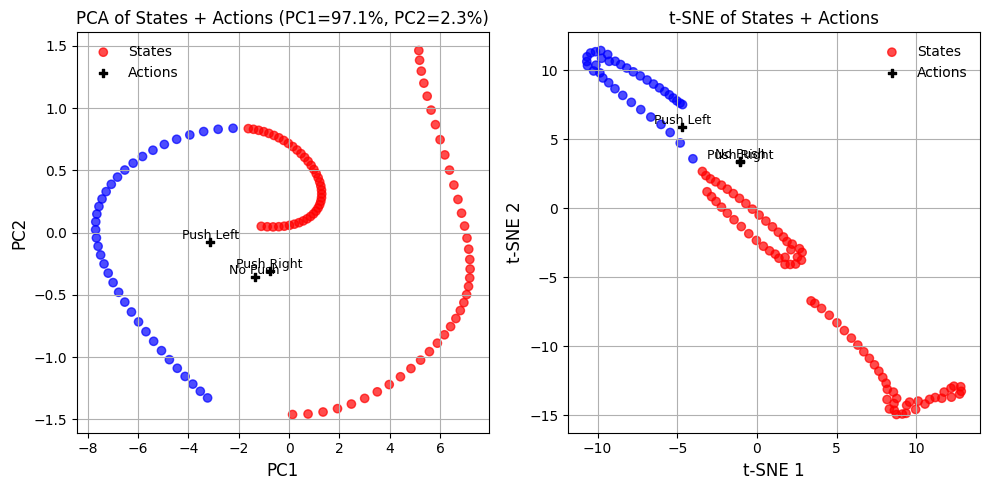

In [48]:
import os
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # still import if needed

# --- Load Trained Models ---
seed = 2
env_name = 'MountainCar-v0'
agent_type = 'ppo'  # regular PPO uses "MlpPolicy"

# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = DummyVecEnv([lambda: env])

# Define model path
model_path = f'models/{env_name}/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    # For regular PPO we assume default "MlpPolicy"
    model = PPO.load(model_path, env=env)
else:
    raise FileNotFoundError(f"Model path {model_path} not found")

# --- Embedding Extraction ---
num_episodes = 1
max_steps = 500

state_embeddings = []
velocity_values = []  # We'll color states by the sign of velocity (index 1 for MountainCar)

for episode in range(num_episodes):
    obs = env.reset()
    ep_return = 0
    for step in range(max_steps):
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        # Extract state embedding using the model's mlp_extractor
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
        
        # MountainCar-v0 observation: [position, velocity]
        velocity = obs[0][1]  # index 1 for velocity
        velocity_values.append(velocity)
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        ep_return += reward
        if done:
            break
    print(f'Return = {ep_return}')

state_embeddings = np.array(state_embeddings)
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[-1])
print("State Embeddings shape:", state_embeddings.shape)
velocity_values = np.array(velocity_values)

# --- Load Action Embeddings ---
# For a regular PPO (MlpPolicy), use the weight matrix from the action network.
action_embeddings = model.policy.action_net.weight.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)

# --- Prepare 2-Color Scheme for States Based on Velocity ---
# Color states 'blue' if velocity < 0, and 'red' if velocity >= 0
state_colors = np.where(velocity_values >= 0, 'red', 'blue')

# --- Combine States and Actions for PCA & t-SNE ---
combined = np.vstack([state_embeddings, action_embeddings])

pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
combined_tsne = tsne.fit_transform(combined)

tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plotting ---
plt.figure(figsize=(10, 5))

# Action labels for MountainCar (3 discrete actions)
action_labels = ["Push Left", "No Push", "Push Right"]

# PCA subplot
plt.subplot(1, 2, 1)
plt.scatter(pca_states[:, 0], pca_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# t-SNE subplot
plt.subplot(1, 2, 2)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Taxi v3

Return = [11.]
Return = [7.]
Return = [6.]
Return = [12.]
Return = [9.]
State Embeddings shape: (60, 128)
Action Embeddings Shape: (6, 128)


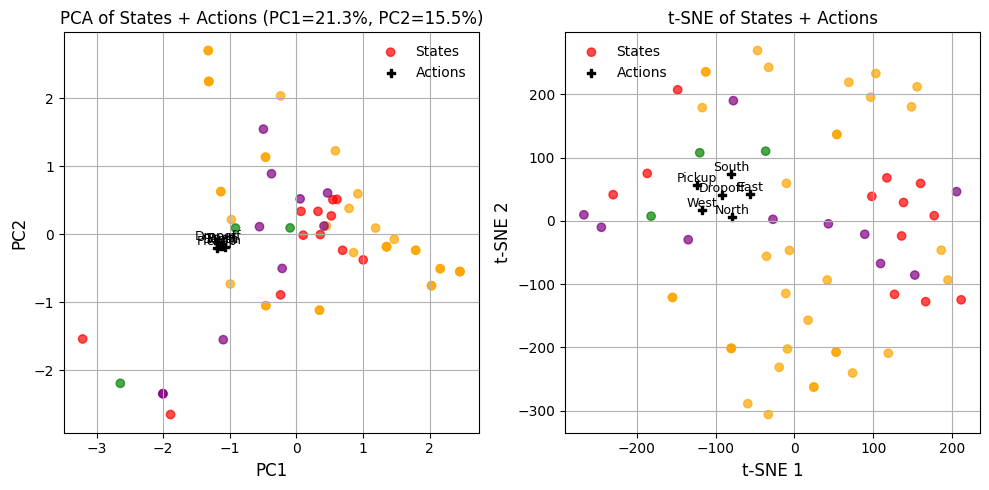

In [55]:
import os
import gymnasium as gym
from gymnasium import spaces
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import custom policy if needed

# --- Define One-Hot Encoding Wrapper ---
class OneHotWrapper(gym.ObservationWrapper):
    """ Converts discrete state into a one-hot vector for compatibility with trained models. """
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = spaces.Box(low=0, high=1, shape=(500,), dtype=np.float32)

    def observation(self, obs):
        one_hot = np.zeros(500, dtype=np.float32)
        one_hot[obs] = 1.0
        return one_hot

# --- Load Trained Models ---
seed = 2
env_name = 'Taxi-v3'
agent_type = 'ppo-harmonic'  # Change to 'ppo' if needed

# Create and wrap environment
env = gym.make(env_name)
env = OneHotWrapper(env)  # Ensure it matches training setup
env = DummyVecEnv([lambda: env])

# Define model path
model_path = f'models/{env_name}/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    if agent_type == "ppo-harmonic":
        custom_objects = {"policy_class": HarmonicPolicy}
        model = PPO.load(model_path, env=env, custom_objects=custom_objects)
    else:
        model = PPO.load(model_path, env=env)
else:
    raise FileNotFoundError(f"Model path {model_path} not found")

# --- Embedding Extraction ---
num_episodes = 5
max_steps = 200

state_embeddings = []
pickup_status = []  # We'll color states based on pickup/dropoff state

for episode in range(num_episodes):
    obs  = env.reset()
    ep_return = 0
    for step in range(max_steps):
        obs_tensor = torch.tensor([obs], dtype=torch.float32)  # Convert one-hot state to tensor
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())

        # Extract passenger status (from encoded state)
        taxi_env = env.envs[0].unwrapped  # Get the unwrapped Taxi-v3 env
        taxi_row, taxi_col, pass_loc, dest_loc = taxi_env.decode(obs.argmax())  # Convert one-hot back to state
        pickup_status.append(pass_loc)  # Different passenger locations

        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _ = env.step(action)
        ep_return += reward
        if done:
            break
    print(f'Return = {ep_return}')

state_embeddings = np.array(state_embeddings)
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[-1])
print("State Embeddings shape:", state_embeddings.shape)

pickup_status = np.array(pickup_status)

# --- Load Action Embeddings ---
harmonic_policy = model.policy
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)

# --- Color Coding for Pickup Status ---
colors = ['blue', 'green', 'red', 'purple', 'orange']
state_colors = [colors[p] for p in pickup_status]  # Assign colors based on pickup location

# --- Combine States and Actions for PCA & t-SNE ---
combined = np.vstack([state_embeddings, action_embeddings])

pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
combined_tsne = tsne.fit_transform(combined)

tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plotting ---
plt.figure(figsize=(10, 5))

# Taxi-v3 actions
action_labels = ["South", "North", "East", "West", "Pickup", "Dropoff"]

# PCA subplot
plt.subplot(1, 2, 1)
plt.scatter(pca_states[:, 0], pca_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# t-SNE subplot
plt.subplot(1, 2, 2)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Lunar Lander

Return = [225.15045]
State Embeddings shape: (328, 128)
Action Embeddings Shape: (4, 128)


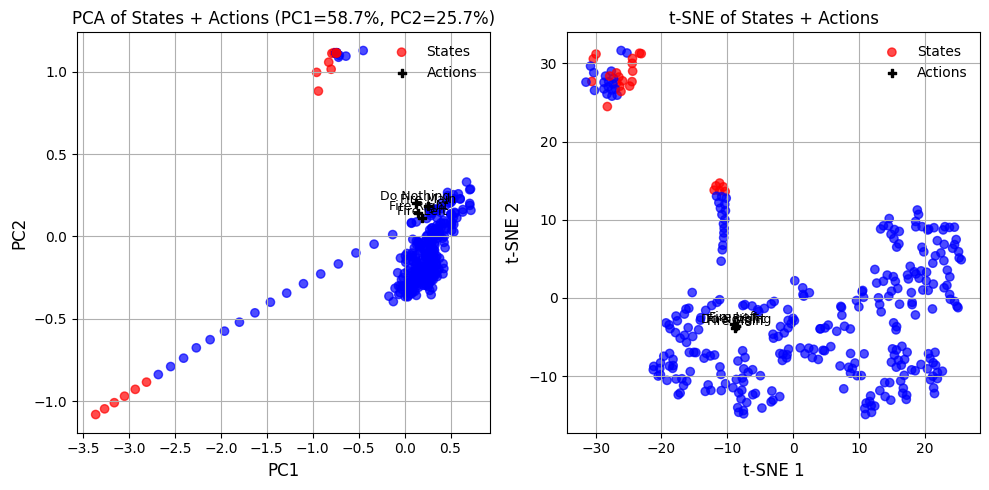

In [43]:
import os
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import your custom policy if needed

# --- Load Trained Models ---
seed = 2
env_name = 'LunarLander-v2'
agent_type = 'ppo-harmonic'

# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = DummyVecEnv([lambda: env])

# Define model path
model_path = f'models/{env_name}/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    if agent_type == "ppo-harmonic":
        # Load with custom_objects to ensure the HarmonicPolicy is used
        custom_objects = {"policy_class": HarmonicPolicy}
        model = PPO.load(model_path, env=env, custom_objects=custom_objects)
    else:
        model = PPO.load(model_path, env=env)
else:
    raise FileNotFoundError(f"Model path {model_path} not found")

# --- Embedding Extraction ---
num_episodes = 1
max_steps = 500

state_embeddings = []
velocity_values = []  # We'll use vertical velocity (index 3) for LunarLander

for episode in range(num_episodes):
    obs = env.reset()
    ep_return = 0
    for step in range(max_steps):
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        # Extract state embedding using the model's mlp_extractor
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
        
        # LunarLander-v2 observation: [x, y, x_vel, y_vel, angle, angular_vel, left_leg, right_leg]
        # We'll color by the vertical velocity (y_vel) => index 3
        y_vel = obs[0][3]
        velocity_values.append(y_vel)
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        ep_return += reward
        if done:
            break
    print(f'Return = {ep_return}')

# Convert to numpy arrays
state_embeddings = np.array(state_embeddings)
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[-1])
print("State Embeddings shape:", state_embeddings.shape)

velocity_values = np.array(velocity_values)

# --- Load Action Embeddings ---
harmonic_policy = model.policy
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)

# --- Prepare 2-Color Scheme for States Based on Vertical Velocity ---
# Color states 'blue' if y_vel < 0, and 'red' if y_vel >= 0
state_colors = np.where(velocity_values >= 0, 'red', 'blue')

# --- Combine States and Actions for PCA & t-SNE ---
combined = np.vstack([state_embeddings, action_embeddings])

pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
combined_tsne = tsne.fit_transform(combined)

tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plotting ---
plt.figure(figsize=(10, 5))

# Action labels for LunarLander-v2 (4 discrete actions)
action_labels = ["Do Nothing", "Fire Left", "Fire Main", "Fire Right"]

# PCA subplot
plt.subplot(1, 2, 1)
plt.scatter(pca_states[:, 0], pca_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# t-SNE subplot
plt.subplot(1, 2, 2)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

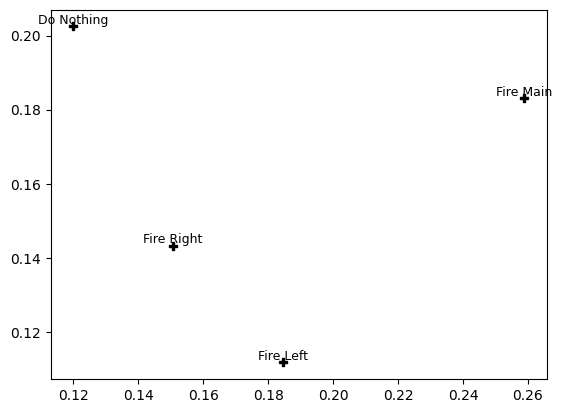

In [44]:
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

Return = [225.15045]
State Embeddings shape: (328, 128)
Action Embeddings Shape: (4, 128)


/var/folders/y2/808x0vrs0219dlwh974ks0q00000gn/T/ipykernel_81254/2423850693.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('bwr')


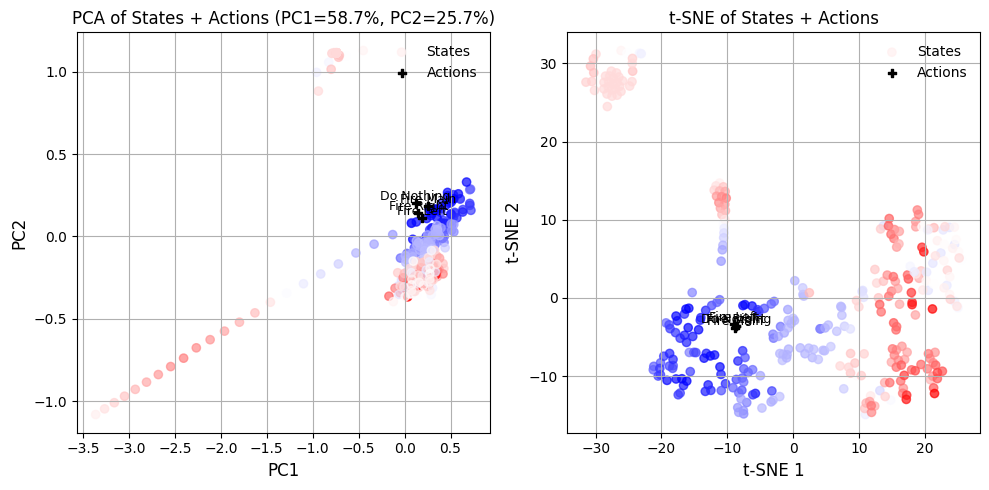

In [45]:
import os
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.colors as colors
import matplotlib.cm as cm
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.utils_custom_policies import HarmonicPolicy  # Import your custom policy if needed

# --- Load Trained Models ---
seed = 2
env_name = 'LunarLander-v2'
agent_type = 'ppo-harmonic'

# Create environment (assuming same settings as training)
env = gym.make(env_name)
env.reset(seed=seed)
env = DummyVecEnv([lambda: env])

# Define model path
model_path = f'models/{env_name}/{agent_type}_{seed}.zip'
if os.path.exists(model_path):
    if agent_type == "ppo-harmonic":
        custom_objects = {"policy_class": HarmonicPolicy}
        model = PPO.load(model_path, env=env, custom_objects=custom_objects)
    else:
        model = PPO.load(model_path, env=env)
else:
    raise FileNotFoundError(f"Model path {model_path} not found")

# --- Embedding Extraction ---
num_episodes = 1
max_steps = 500

state_embeddings = []
angle_values = []  # We'll color states by angle => index 4 in LunarLander

for episode in range(num_episodes):
    obs = env.reset()
    ep_return = 0
    for step in range(max_steps):
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        features_pi, _ = model.policy.mlp_extractor(obs_tensor)
        state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
        
        # LunarLander-v2 observation: [x, y, x_dot, y_dot, theta, theta_dot, leg1_contact, leg2_contact]
        # We'll color by 'theta' => index 4
        theta = obs[0][4]
        angle_values.append(theta)
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        ep_return += reward
        if done:
            break
    print(f'Return = {ep_return}')

state_embeddings = np.array(state_embeddings)
state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[-1])
print("State Embeddings shape:", state_embeddings.shape)

angle_values = np.array(angle_values)

# --- Load Action Embeddings ---
harmonic_policy = model.policy
action_embeddings = harmonic_policy.weights.detach().cpu().numpy()
print("Action Embeddings Shape:", action_embeddings.shape)

# --- Gradient colormap for states based on angle (theta) ---
# We'll center at 0, so negative angles are blue, positive angles are red, near zero is white
norm = colors.TwoSlopeNorm(vmin=angle_values.min(), vcenter=0, vmax=angle_values.max())
cmap = cm.get_cmap('bwr')
state_colors = cmap(norm(angle_values))

# --- Combine States and Actions for PCA & t-SNE ---
combined = np.vstack([state_embeddings, action_embeddings])

pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined)

num_states = state_embeddings.shape[0]
pca_states = combined_pca[:num_states]
pca_actions = combined_pca[num_states:]

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
combined_tsne = tsne.fit_transform(combined)

tsne_states = combined_tsne[:num_states]
tsne_actions = combined_tsne[num_states:]

# --- Plotting ---
plt.figure(figsize=(10, 5))

# Action labels for LunarLander-v2 (4 discrete actions)
action_labels = ["Do Nothing", "Fire Left", "Fire Main", "Fire Right"]

# PCA subplot
plt.subplot(1, 2, 1)
plt.scatter(pca_states[:, 0], pca_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(pca_actions[:, 0], pca_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = pca_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

var_ratio = pca.explained_variance_ratio_
pc1, pc2 = var_ratio[0] * 100, var_ratio[1] * 100
plt.title(f"PCA of States + Actions (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()

# t-SNE subplot
plt.subplot(1, 2, 2)
plt.scatter(tsne_states[:, 0], tsne_states[:, 1], c=state_colors, alpha=0.7, label='States')
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

plt.title("t-SNE of States + Actions")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

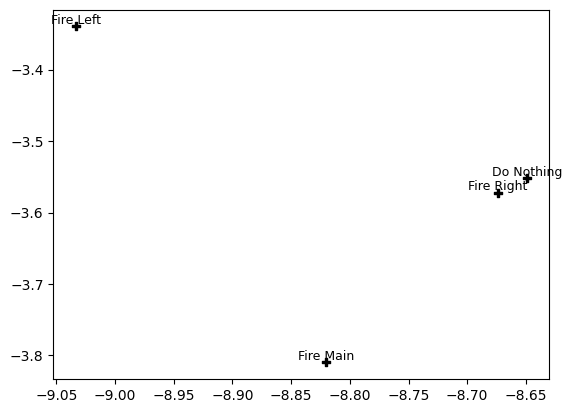

In [46]:
plt.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='black', marker='P', label='Actions')
for i, label in enumerate(action_labels):
    x, y = tsne_actions[i]
    plt.annotate(label, (x, y), fontsize=9, ha='center', va='bottom')

=== ENV: CartPole-v1 ===
[ppo] Return = [149.]
[ppo-harmonic] Return = [32.]


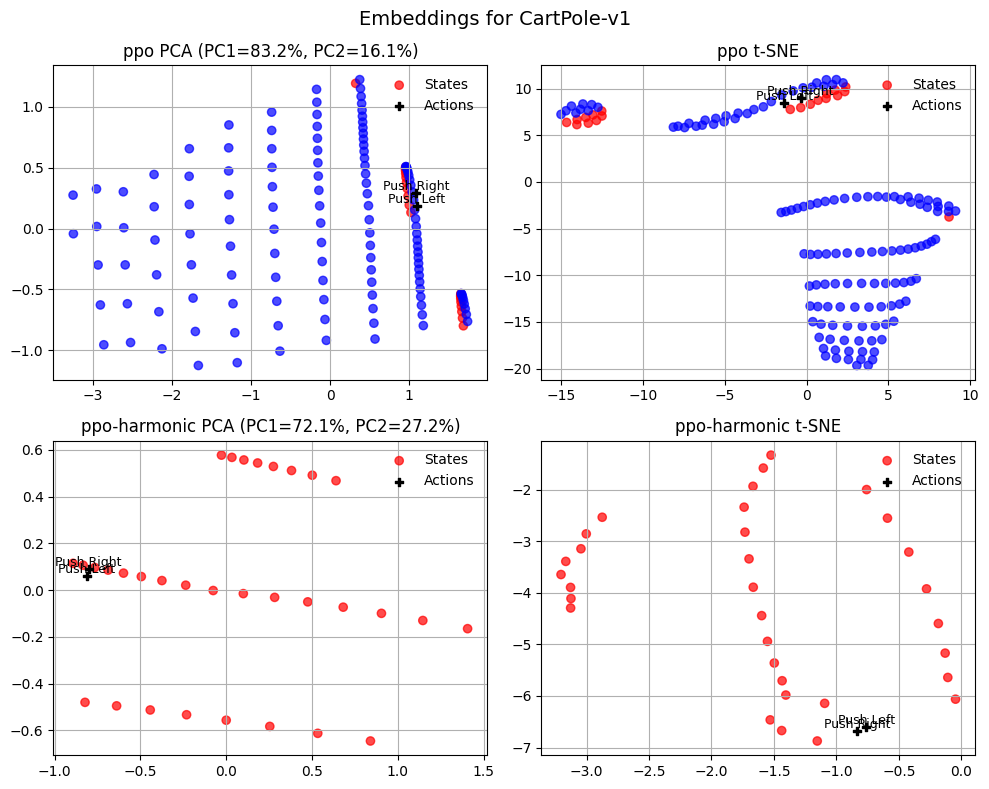

-----

=== ENV: Acrobot-v1 ===
[ppo] Return = [-62.]
[ppo-harmonic] Return = [-69.]


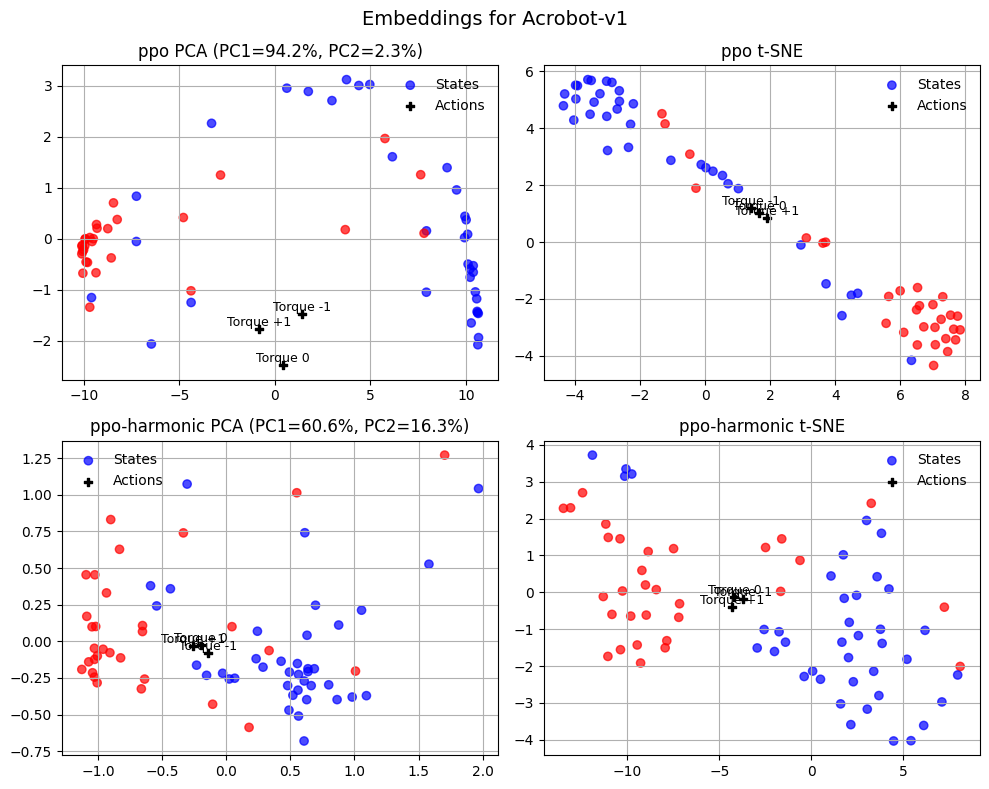

-----

=== ENV: MountainCar-v0 ===
[ppo] Return = [-115.]
[ppo-harmonic] Return = [-114.]


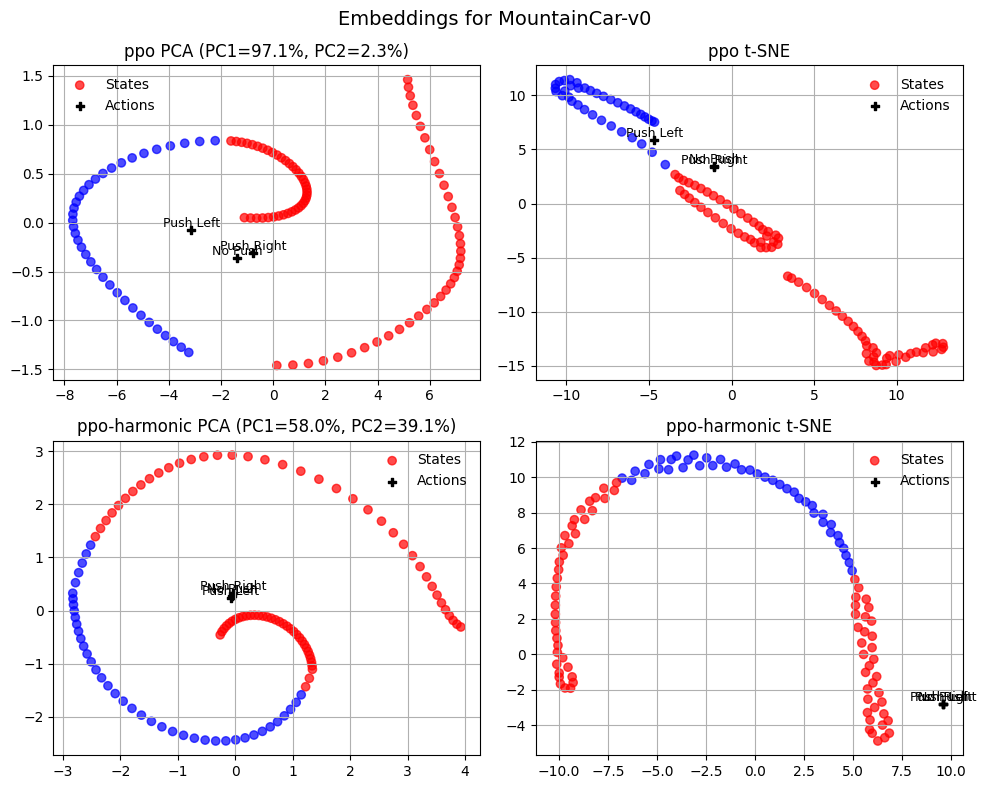

-----

=== ENV: LunarLander-v2 ===
[ppo] Return = [243.69424]
[ppo-harmonic] Return = [225.15045]


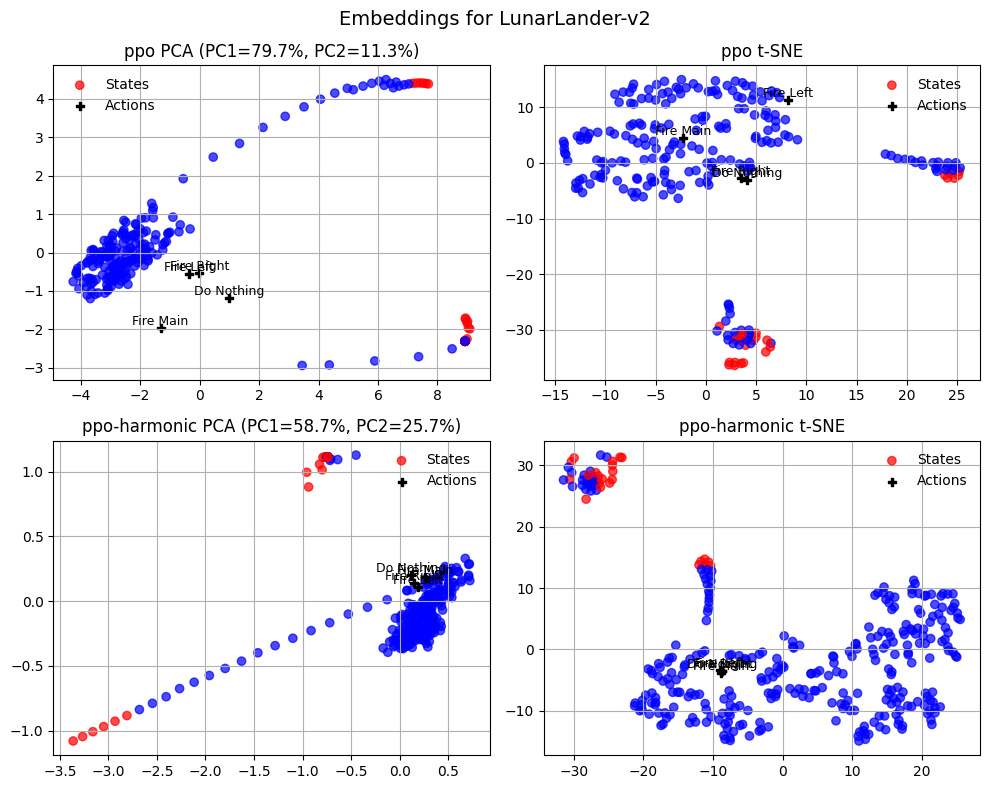

-----



In [50]:
import os
import gymnasium as gym
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

from utils.utils_custom_policies import HarmonicPolicy  # If needed for ppo-harmonic

###############################
# Configuration
###############################
env_list = ["CartPole-v1", "Acrobot-v1", "MountainCar-v0", "LunarLander-v2"]
agent_types = ["ppo", "ppo-harmonic"]
seed = 2
max_steps = 500
num_episodes = 1

# Define how we color states in each environment
# (index in the observation array and a short description)
# For example:
#   CartPole: index 2 = pole angle
#   Acrobot: index 5 = thetaDot2
#   MountainCar: index 1 = velocity
#   LunarLander: index 3 = vertical velocity
color_idx_map = {
    "CartPole-v1": 2,
    "Acrobot-v1": 5,
    "MountainCar-v0": 1,
    "LunarLander-v2": 3,
}

# Define how many actions and how to label them
# Adjust as needed for your environment
action_label_map = {
    "CartPole-v1": ["Push Left", "Push Right"],
    "Acrobot-v1":  ["Torque -1", "Torque 0", "Torque +1"],
    "MountainCar-v0": ["Push Left", "No Push", "Push Right"],
    "LunarLander-v2": ["Do Nothing", "Fire Left", "Fire Main", "Fire Right"],
}

def color_scheme(vals):
    """
    Example: 2-color scheme, red if >= 0, blue if < 0.
    For a more sophisticated approach (like gradient),
    you can adapt this function.
    """
    return np.where(vals >= 0, 'red', 'blue')

###############################
# Main Loop
###############################
for env_name in env_list:
    print(f"=== ENV: {env_name} ===")
    
    # Create environment
    env = gym.make(env_name)
    env.reset(seed=seed)
    env = DummyVecEnv([lambda: env])
    
    # Which observation index to color by?
    color_idx = color_idx_map.get(env_name, 0)
    
    # Action labels
    action_labels = action_label_map.get(env_name, [])
    num_actions = len(action_labels)
    
    # Prepare figure: 2 rows (ppo vs ppo-harmonic) x 2 cols (pca, tsne)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    fig.suptitle(f"Embeddings for {env_name}", fontsize=14)
    
    for row, agent_type in enumerate(agent_types):
        # Load model
        if agent_type == 'CartPole-v1':
            seed = 11
        else:
            seed = 2
        model_path = f"models/{env_name}/{agent_type}_{seed}.zip"
        if not os.path.exists(model_path):
            print(f"Model not found: {model_path}")
            # skip if model doesn't exist
            continue
        
        if agent_type == "ppo-harmonic":
            custom_objects = {"policy_class": HarmonicPolicy}
            model = PPO.load(model_path, env=env, custom_objects=custom_objects)
        else:
            model = PPO.load(model_path, env=env)
        
        # Collect embeddings
        state_embeddings = []
        color_values = []
        
        for ep in range(num_episodes):
            obs = env.reset()
            ep_return = 0
            for step in range(max_steps):
                obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
                features_pi, _ = model.policy.mlp_extractor(obs_tensor)
                state_embeddings.append(features_pi.detach().squeeze(0).cpu().numpy())
                
                # Grab the chosen variable from the observation
                # If the env observation is smaller than color_idx, handle carefully
                cval = obs[0][color_idx]
                color_values.append(cval)
                
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, done, info = env.step(action)
                ep_return += reward
                if done:
                    break
            print(f"[{agent_type}] Return = {ep_return}")
        
        # Convert to np array
        state_embeddings = np.array(state_embeddings)
        state_embeddings = state_embeddings.reshape(-1, state_embeddings.shape[-1])
        
        # Action embeddings
        if agent_type == "ppo-harmonic":
            # distance-based
            action_embeddings = model.policy.weights.detach().cpu().numpy()
        else:
            # standard ppo
            action_embeddings = model.policy.action_net.weight.detach().cpu().numpy()
        
        # Combine
        combined = np.vstack([state_embeddings, action_embeddings])
        
        # PCA
        pca = PCA(n_components=2)
        combined_pca = pca.fit_transform(combined)
        
        num_states = state_embeddings.shape[0]
        pca_states = combined_pca[:num_states]
        pca_actions = combined_pca[num_states:]
        
        # t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=20)
        combined_tsne = tsne.fit_transform(combined)
        tsne_states = combined_tsne[:num_states]
        tsne_actions = combined_tsne[num_states:]
        
        # Prepare colors for states
        color_values = np.array(color_values)
        state_colors = color_scheme(color_values)
        
        # Plot PCA (left col = col 0)
        ax_pca = axes[row, 0]
        ax_pca.scatter(pca_states[:, 0], pca_states[:, 1], c=state_colors, alpha=0.7, label='States')
        ax_pca.scatter(pca_actions[:, 0], pca_actions[:, 1], c='black', marker='P', label='Actions')
        
        # Annotate actions if the dimension matches
        for i in range(min(num_actions, pca_actions.shape[0])):
            x, y = pca_actions[i]
            ax_pca.annotate(action_labels[i], (x, y), fontsize=9, ha='center', va='bottom')
        
        var_ratio = pca.explained_variance_ratio_
        pc1, pc2 = var_ratio[0]*100, var_ratio[1]*100
        ax_pca.set_title(f"{agent_type} PCA (PC1={pc1:.1f}%, PC2={pc2:.1f}%)")
        ax_pca.grid(True)
        
        # Plot t-SNE (right col = col 1)
        ax_tsne = axes[row, 1]
        ax_tsne.scatter(tsne_states[:, 0], tsne_states[:, 1], c=state_colors, alpha=0.7, label='States')
        ax_tsne.scatter(tsne_actions[:, 0], tsne_actions[:, 1], c='black', marker='P', label='Actions')
        
        for i in range(min(num_actions, tsne_actions.shape[0])):
            x, y = tsne_actions[i]
            ax_tsne.annotate(action_labels[i], (x, y), fontsize=9, ha='center', va='bottom')
        
        ax_tsne.set_title(f"{agent_type} t-SNE")
        ax_tsne.grid(True)
    
    # Adjust layout
    for axrow in axes:
        for ax in axrow:
            ax.legend()
    plt.tight_layout()
    plt.show()
    print("-----\n")